In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import RNN, Layer
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow import float32, concat, convert_to_tensor, linalg
import tensorflow as tf
import os 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgGjA5KAO9MKflOlTlZuVanMdCZLm4HzLxNjiuo8LZfd4ZewTTy3sY
Mounted at /content/drive


In [ ]:
#import scipy.io
#dataDir = "/content/drive/MyDrive/Major Project/New/Data/Training Datasets/phy/"
#mat = scipy.io.loadmat(dataDir + 'data_num.mat')
#print(np.array(mat['input_tf']).shape)
#utrain= pd.DataFrame(mat['input_tf'][2])
#print(utrain.describe())
#ytrain= pd.DataFrame(mat['target_X_tf'][2])
#print(ytrain.describe())
#print(utrain.shape," ",ytrain.shape)
#utrain =np.array([utrain[0].values[:,np.newaxis]])*-1

#ytrain = np.array([ytrain[0].values[:,np.newaxis]])
#print(utrain.shape," ",ytrain.shape)
#print(utrain)

In [3]:
dataDir = "/content/drive/MyDrive/Major Project/New/Data/Training Datasets/aaaa/EL.txt"
U=np.genfromtxt(dataDir,delimiter='',skip_header=1)

print(U.shape)
columns=["id","time","Force","Displacement","Velocity","Acceleration","Spring Force","Damping Force","Inertial Force","Total Accel","Total Inertial","SpringDampRelInert","SpringDampTotalInert"]
df=pd.DataFrame(U,columns=columns)
df.head()

(2674, 13)


,id,time,Force,Displacement,Velocity,Acceleration,Spring Force,Damping Force,Inertial Force,Total Accel,Total Inertial,SpringDampRelInert,SpringDampTotalInert
0,1.0,0.02,0.000306,-0.000064,-0.008568,-0.743347,-0.001310,-0.001114,-0.385054,-0.625147,-0.323827,-0.387478,-0.326251
1,2.0,0.04,0.001937,-0.000512,-0.042515,-2.646332,-0.010435,-0.005528,-1.370801,-1.897732,-0.983026,-1.386765,-0.998989
2,3.0,0.06,0.006934,-0.001786,-0.079547,-1.051440,-0.036425,-0.010343,-0.544646,1.627760,0.843181,-0.591414,0.796413
3,4.0,0.08,0.002957,-0.003582,-0.099833,-0.975608,-0.073068,-0.012981,-0.505365,0.166992,0.086502,-0.591414,0.000453
4,5.0,0.10,0.002957,-0.005833,-0.128266,-1.864055,-0.118994,-0.016678,-0.965581,-0.721455,-0.373714,-1.101254,-0.509387


In [4]:
data_path="/content/drive/MyDrive/Major Project/New/Data/Training Datasets/sap2000_1dof_nonlinear_analysis_results"
data=[]
for path in os.listdir(data_path):
  file_path=os.path.join(data_path,path)
  data.append(np.genfromtxt(file_path,delimiter='',skip_header=14))
  print(file_path)

data=np.array(data)
print(data.shape)

/content/drive/MyDrive/Major Project/New/Data/Training Datasets/sap2000_1dof_nonlinear_analysis_results/nonlin_an01.txt
/content/drive/MyDrive/Major Project/New/Data/Training Datasets/sap2000_1dof_nonlinear_analysis_results/nonlin_an02.txt
/content/drive/MyDrive/Major Project/New/Data/Training Datasets/sap2000_1dof_nonlinear_analysis_results/nonlin_an03.txt
/content/drive/MyDrive/Major Project/New/Data/Training Datasets/sap2000_1dof_nonlinear_analysis_results/nonlin_an04.txt
/content/drive/MyDrive/Major Project/New/Data/Training Datasets/sap2000_1dof_nonlinear_analysis_results/nonlin_an05.txt
(5, 1001, 5)


In [ ]:

class RungeKuttaIntegratorCell(Layer):
    def __init__(self, m, c, k, dt, initial_state, **kwargs):
        super(RungeKuttaIntegratorCell, self).__init__(**kwargs)
        self.Minv = linalg.inv(np.diag(m))
        self._c   = c
        self.K    = self._getCKmatrix(k)
        self.initial_state = initial_state
        self.state_size    = 2*len(m)
        self.A  = np.array([0., 0.5, 0.5, 1.0], dtype='float32')
        self.B  = np.array([[1/6, 2/6, 2/6, 1/6]], dtype='float32')
        self.dt = dt

    def build(self, input_shape, **kwargs):
        self.kernel = self.add_weight("C", shape = self._c.shape, trainable = True, initializer = lambda shape, dtype: self._c, **kwargs)
        self.built  = True

    def call(self, inputs, states):
        C    = self._getCKmatrix(self.kernel)
        y    = states[0][:,:1]
        ydot = states[0][:,1:]
        print("Shape of the State: ",len(states)," ",len(states[0])," ",len(states[0][0]),"\n")
        print("current C value: ",C)
        print("Shape of the inputs: ",len(inputs),len(inputs[0]))
        
        yddoti = self._fun(self.Minv, self.K, C, inputs, y, ydot)
        yi     = y + self.A[0] * ydot * self.dt
        ydoti  = ydot + self.A[0] * yddoti * self.dt
        fn     = self._fun(self.Minv, self.K, C, inputs, yi, ydoti)
        for j in range(1,4):
            yn    = y + self.A[j] * ydot * self.dt
            ydotn = ydot + self.A[j] * yddoti * self.dt
            ydoti = concat([ydoti, ydotn], axis=0)
            fn    = concat([fn, self._fun(self.Minv, self.K, C, inputs, yn, ydotn)], axis=0)

        y    = y + linalg.matmul(self.B, ydoti) * self.dt
        ydot = ydot + linalg.matmul(self.B, fn) * self.dt
        return y, [concat(([y, ydot]), axis=-1)]

    def _fun(self, Minv, K, C, u, y, ydot):
        return linalg.matmul(u - linalg.matmul(ydot, C, transpose_b=True) - linalg.matmul(y, K, transpose_b=True), Minv, transpose_b=True)
                             
    def _getCKmatrix(self, a):
        return convert_to_tensor([[a[0]]], dtype=float32)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return self.initial_state

In [ ]:
a = tf.constant(np.arange(1, 2, dtype=np.int32), shape=[1,1])
print(a)
b = tf.constant(np.arange(5, 6, dtype=np.int32), shape=[1,1])
print(b)
print(linalg.matmul(a,b))
a1=np.arange(1,2,dtype=np.int32).reshape((1,1))
print(a1)
b1=np.arange(5,6,dtype=np.int32).reshape((1,1))
print(b1)
print(tf.constant(a1))
print(tf.constant(np.matmul(a1,b1)))
#print(linalg.inv(np.diag(m)))
# print(linalg.matmul(, C, transpose_b=True))

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[5]], shape=(1, 1), dtype=int32)
tf.Tensor([[5]], shape=(1, 1), dtype=int32)
[[1]]
[[5]]
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[5]], shape=(1, 1), dtype=int32)


In [ ]:
U=data[0]
print(U.shape)
columns=["Time","Ground_acc","Disp"]
df=pd.DataFrame(U[:,:3],columns=columns)
df.head()

(1001, 5)


,Time,Ground_acc,Disp
0,0.00,-0.00313,0.000000
1,0.02,-0.00313,0.000000
2,0.04,-0.00313,0.000002
3,0.06,-0.00313,0.000004
4,0.08,-0.00312,0.000008


In [ ]:
utrain=data[:,:,2]*(50.66066e3)
utrain=np.expand_dims(utrain, axis=-1)
print(utrain.shape)
ytrain=data[:,:,3]*-1
ytrain=np.expand_dims(ytrain, axis=-1)
print(ytrain.shape)

(5, 1001, 1)
(5, 1001, 1)


In [ ]:
# data
# df = pd.read_csv('/content/drive/MyDrive/Major Project/New/Data/Training Datasets/phy/1dof_newbarks - Sheet1.csv')
# t  = df["Time"]
# dt = 0.02
# utrain = df[['Force']].values[np.newaxis, :, :]*200
# ytrain = df[['Displacement']].values[np.newaxis, :, :]*-1
# print(df.describe)

In [ ]:

def create_model(m, c, k, dt, initial_state, batch_input_shape, return_sequences = True, unroll = False):
    rkCell = RungeKuttaIntegratorCell(m=m, c=c, k=k, dt=dt, initial_state=initial_state)
    PINN   = RNN(cell=rkCell, batch_input_shape=batch_input_shape, return_sequences=return_sequences, return_state=False, unroll=unroll,stateful=True)
    model  = Sequential()
    model.add(PINN)
    model.compile(loss='mse', optimizer=RMSprop(5000), metrics=['mae'])
    return model

In [ ]:
 # masses, spring coefficients, and damping coefficients
m = np.array([50.66066e3], dtype='float32')
c = np.array([500], dtype='float32') # initial guess
k = np.array([2000e3], dtype='float32')

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# print(df["Force"].head())
# df[["Force"]] = scaler.fit_transform(df[["Force"]])
# print(df["Force"].head())

(5, 1001, 1) (5, 1001, 1)


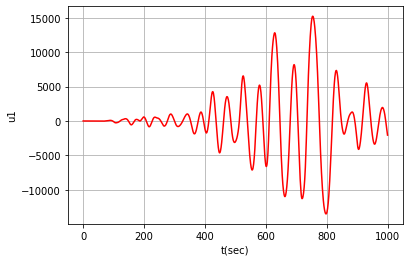

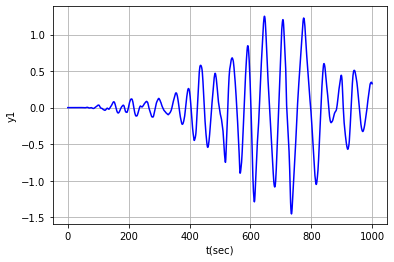

In [ ]:
print(ytrain.shape,utrain.shape)
plt.figure()
plt.plot( utrain[0, :], 'r',label='m1')
plt.xlabel('t(sec)')
plt.ylabel('u1')
plt.grid('on')

plt.figure()
plt.plot( ytrain[0, :], 'b',label='y1')
plt.xlabel('t(sec)')
plt.ylabel('y1')
plt.grid('on')


In [ ]:
#np.linalg.inv(np.diag(m))

In [ ]:
    # fitting physics-informed neural network
initial_state =np.zeros((1,2 * len(m),), dtype='float32')
model = create_model(m, c, k, 0.02, initial_state=initial_state, batch_input_shape=utrain[:1].shape)
print(model.summary())
yPred_before = model.predict_on_batch(utrain[0:1])[0, :]
# for j in range(100):
#       for i in range(5):
                  
history = model.fit(utrain, ytrain, epochs=100, steps_per_epoch=5, verbose=1)

yPred   = model.predict_on_batch(utrain[0:1])[0, :]

Shape of the State:  1   1   2 

current C value:  Tensor("rnn_24/runge_kutta_integrator_cell_24/packed:0", shape=(1, 1), dtype=float32)
Shape of the inputs:  1 1
Shape of the State:  1   1   2 

current C value:  Tensor("rnn_24/while/runge_kutta_integrator_cell_24/packed:0", shape=(1, 1), dtype=float32)
Shape of the inputs:  1 1
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_24 (RNN)                 (1, 1001, 1)              1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________
None
Shape of the State:  1   1   2 

current C value:  Tensor("sequential_24/rnn_24/runge_kutta_integrator_cell_24/packed:0", shape=(1, 1), dtype=float32)
Shape of the inputs:  1 1
Shape of the State:  1   1   2 

current C value:  Tensor("sequential_24/rnn_24/while/runge_kutta_integrator_cell_24/packed:0", shape=(1, 1

(1001, 1)


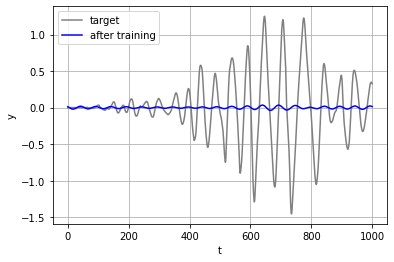

[[0.01199492]
 [0.0096911 ]
 [0.00724996]
 ...
 [0.01834384]
 [0.01659026]
 [0.01457167]]


In [ ]:
    # plotting prediction results
print(yPred.shape)
plt.plot( ytrain[0, :], 'gray',label='target')
# plt.plot( yPred_before, 'r', label='before training')
plt.plot( model.predict_on_batch(utrain[0:1])[0, :], 'b', label='after training')
plt.xlabel('t')
plt.ylabel('y')
plt.grid('on')
plt.legend()
plt.show()
print(yPred)

In [ ]:
dt

NameError: ignored

In [ ]:
c

In [ ]:
print(history.history.keys())
plt.figure()
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['mae'])
# plt.plot(history.history['val_loss'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Major Project/New/Data/Training Datasets/phy/newbarks_u_02 - Sheet1.csv')
t  = df[['t']].values
dt=0.02
xval = df[['u']].values[np.newaxis, :, :]*(200)
yval = df[['y']].values[np.newaxis, :, :]*-1

ypred=model.predict(xval)
model.evaluate(ypred,yval)

In [ ]:
plt.figure()
plt.plot( xval[0, :, :], 'r',label='m1')
plt.xlabel('t(sec)')
plt.ylabel('u1')
plt.grid('on')

plt.figure()
plt.plot( yval[0, :, :], 'b',label='y1')
plt.xlabel('t(sec)')
plt.ylabel('y1')
plt.grid('on')

In [ ]:
plt.plot( yval[0, :, :], 'r',label='true')
plt.plot( ypred[0,:, :], 'b', label='after training')
plt.xlabel('t')
plt.ylabel('y')
plt.grid('on')
plt.legend()
plt.show()

In [ ]:
print(model.layers[0].get_weights()[0])

[8574.108]
